# Analysis for XMM EPIC-PN Large Window Mode Energy Scale Analysis

## Long-term CTI turned off, Cu K$\alpha$ analysis

**Note:** This workflow starts from an already processed event list to spectra and already fitted Cu K$\alpha$ 8.04 keV line.

All scripts are in `~/GitHub/xmmpy/scripts` folder.

The preliminary processing is done with the following steps:
1. Run `pn_lw_step01.py` to download the ODF and run `cifbuild` and `odfingest`
2. Run `pnlw_nofilt_proc.py <OBS_ID> "noctiy" -c` to process up to spectra. The products will be saved in a subfolder `noctix`, to distinguish it with the `nocti` folder from the previous run with masks per CCD.

In this **new** version, `noctiy`, no mask is applied, the full CCDs are selected at the `evselect` stage, the output spectra and event lists are per CCD. For CCDs 1, 4, 7 and 10 the filtering is for `RAWY in [100:120]`. 

The output products from step 2 are event lists and spectra with the following names:
* Event lists: `pn_XX_patYY_events.fits`
* Spectra: `pn_XX_patYY_spec5.fits`

where `XX` is the CCDNR from 01 to 12, `patYY` is the pattern, can be `pat00` for `PATTERN == 0` or `pat14` for `PATTERN in [1:4]`.

Once the per-CCD spectra are prepared then we proceed with fitting the Cu K$\alpha$ line:

4. Run script `cu_line_analysis_noctiy.py` to fit the Cu K$\alpha$ line and store the results in `fit_results_cuka_noctiy.csv`. 

_Ivan Valtchanov_, 02 Aug 2019


In [1]:
#
# necessary import packages
#
import os
import numpy as np
#import altair as alt
import pandas as pd

from astropy.table import Table, Column
from astropy.io import fits
#from scipy.interpolate import UnivariateSpline
home = os.path.expanduser('~')

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [2]:
def read_cti_ccf(ccf_file,mode_id=2, energy_index=0):
    #
    # utility function to read the EPN CTI calfile and get the dat ain a dictionary
    #
    # mode_id = 0 for PRIME_FULL_WINDOW
    # mode_id = 1 for PRIME_FULL_WINDOW_EXTENDED
    # mode_id = 2 for PRIME_LARGE_WINDOW
    # mode_id = 3 for PRIME_SMALL_WINDOW
    #
    # energy_index = 0 is for Al Ka at 1.486
    # energy_index = 1 is for Mn Ka at 5.8988
    # energy_index = 2 is for Fe Ka at 6.4 keV
    #
    try:
        t = Table.read(f'{ccf_file}',hdu='LONG_TERM_CTI')
        tmp = Table.read(f'{ccf_file}',hdu='LTC_TIMES')
        #times = tmp.data['TIME'][0].flatten()                           
    except:
        print (f"Cannot read CCF file {ccf_file}, it must contain extension with name \"LONG_TERM_CTI\"")
        return None
    times = tmp['TIME'][0]
    tx = t.group_by('MODE_ID')
    mmask = tx.groups.keys['MODE_ID'] == mode_id
    tenergy = tx.groups[mmask].group_by('ENERGY')
    ixxx = np.arange(len(tenergy.groups))
    if (energy_index not in ixxx):
        print (f"The index for the energy {energy_index} is not available for this mode. Only indices: ", ixxx)
        return None
    grp = tenergy.groups[energy_index]
    #print (grp)
    tout = {}
    if (mode_id != 3):
        for iccd in np.arange(1,13):
            xmask = grp['CCD_ID'] == iccd
            tcoeff = grp[xmask]['T_COEFF']
            tout[iccd] = {'mode_id': mode_id, 'ccd': iccd, 'energy': grp['ENERGY'][0],
                'times': times, 'tcoeff': tcoeff[0]}
    else:
        tcoeff = grp['T_COEFF']
        tout[0] = {'mode_id': mode_id, 'ccd': 4, 'energy': grp['ENERGY'][0],
            'times': times, 'tcoeff': tcoeff[0]}
    return tout

## Read the fit results

I use the most recent no CTI version `noctiy`, where the proper `RAWY` selection is done on the boresight CCDs 1, 4, 7 and 10, with `RAWY in [100,120]`

**Note:** In `noctix` the `RAWY` filtering was on CCDs 3, 4, 9 and 10, wrongly assuming these are the boresight CCDs where Cu K$\alpha$ line is only over a limited range of `RAWY` in 100 to 120.

In [3]:
wdir = f"{home}/IVAN/Cu-line"
t = Table.read(f'{wdir}/fit_results_cuka_noctiy.csv',comment="\s*#")
t["ratioE"] = Column(t["lineE"]/8.04)
t["ratioE_err"] = Column(t["lineE_err"]/8.04)
tab = t.to_pandas()

,count,mean,std,min,25%,50%,75%,max
ccd,,,,,,,,
1,68.0,109.817647,0.424243,108.7,109.600,109.90,110.100,110.7
2,68.0,145.073529,3.606487,138.4,141.275,145.45,148.400,150.9
3,68.0,145.882353,3.541858,139.7,142.500,146.10,148.925,151.7
4,68.0,109.763235,0.477213,108.8,109.400,109.80,110.100,110.7
5,68.0,145.191176,3.771366,138.5,141.150,145.35,148.700,151.4
6,68.0,146.194118,3.568556,140.2,142.600,146.70,149.300,152.2
7,68.0,109.863235,0.445845,109.0,109.500,109.80,110.300,110.8
8,68.0,144.920588,4.160495,137.7,140.850,145.60,148.600,150.8
9,68.0,145.051471,4.246772,138.4,140.600,144.90,148.500,152.5


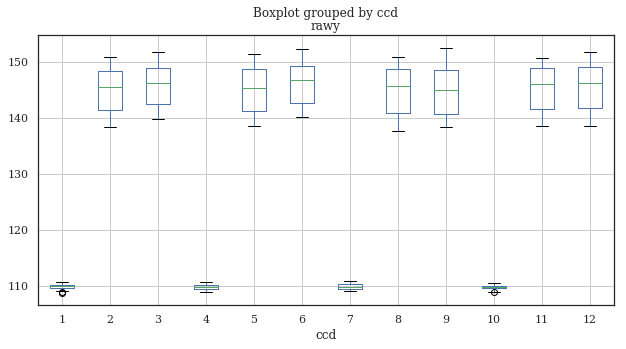

In [5]:
#
# extract the mean RAWY for each CCD
#
boxplot = tab.boxplot(column=['rawy'],by='ccd',figsize=(10,5))
fig = boxplot.get_figure()
fig.savefig(f"{wdir}/boxplot_rawy_all.png",dpi=100)
grouped = tab.groupby('ccd')
rawy = grouped['rawy'].describe()
rawy
#rawy["50%"]
# to get the mean RAWY for a CCD use rawy['mean'].values[CCDNR-1]

## Reading the current CTI CCF

In the following we compare the new results with the current CTI calibration file. The current files `EPN_CTI_0049.CCF` and `EPN_CTI_0050.CCF`, based on my previous analysis of PN-SW and PN-LW are already in the public CCF area `/ccf/pub`.

This means that the updates to the energy at 8.04 keV are simply updating the already existing `TCOEFF` table in the CCF and not adding a new energy point for each CCD.

In [6]:
#
# read the current long-term CCF.
#
ccfdir = '/ccf/valid'
#
# energy_index=0 is for Al Ka (1.486 keV)
# energy_index=1 is for Mn Ka (5.8988 keV)
# energy_index=2 is for Cu Ka (8.04 keV)
#
tcuka = read_cti_ccf(f"{ccfdir}/EPN_CTI_0050.CCF",mode_id=2,energy_index=2)

tt = tcuka[1]['times']

cti = {}
coef = {}
a0 = {}
for i in range(12):
    ccd = i+1
    mean_rawy = rawy['mean'].values[i]
    cti[ccd] = {'x':[],'y':[]}
    cti[ccd]['x'] = tt
    coef[ccd] = tcuka[ccd]['tcoeff']
    a0[ccd] = coef[ccd][0]
    cti[ccd]['y'] = np.power((1.0 - coef[ccd])/(1.0 - a0[ccd]),mean_rawy)
#

## The long-term CTI effect in terms of E_obs/E_lab

Derive a correction curve as polynomial of 4th order and plot the results. Will also add the current curve from the latest `EPN_CTI_0050.CCF`.

We expect a difference only for the central 4 CCDs, because the derived curve in the latest CCF was not based on `RAWY` selection. Hence the mean `RAWY` for those CCDs were not correct. 


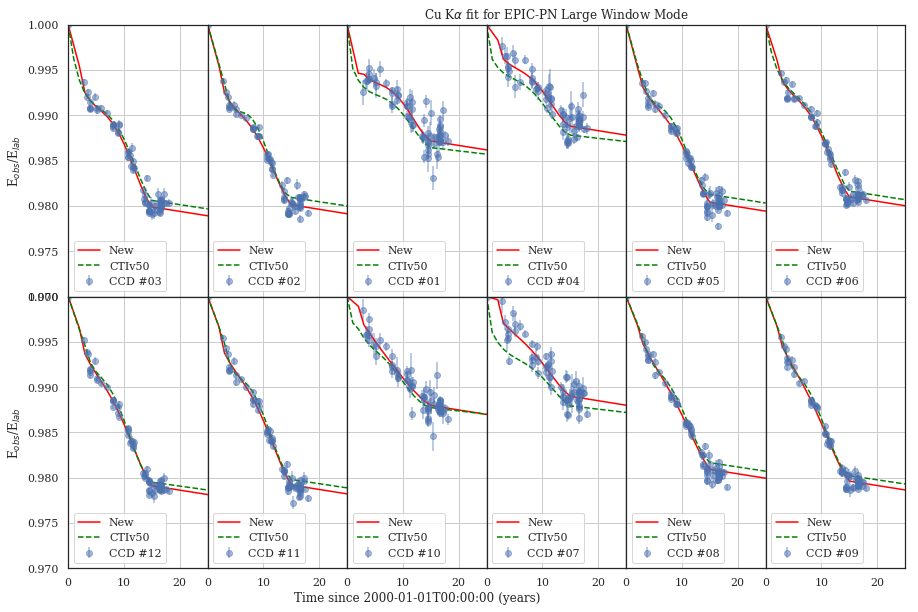

In [70]:
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
stab = tab.sort_values(['delta_time'])
#
#
# CCD position in plot
#
mapping = {1: [0,2], 2: [0,1], 3: [0,0], 4: [0,3], 5: [0,4], 6: [0,5],
          7: [1,3], 8: [1,4], 9: [1,5], 10: [1,2], 11: [1,1], 12: [1,0]}
#
residuals = {}
results = {}
residuals_err = {}
xout = {}
residuals[0] = {'x': [], 'y': [], 'yerr': []}
#
fit_result = {}
#
for j in range(12):
    ccd = j+1
    xtab = stab[(stab.ccd == ccd) & (stab.ratioE <= 1.0)]
    #
    xin = xtab.delta_time
    yin = xtab.ratioE
    yin_err = xtab.ratioE_err
    #
    # now the fitting
    #
    residuals[ccd] = {'x': [], 'y': [], 'yerr': []}
    #
    poly_order = 4
    #if (ccd == 1 or ccd == 7 or ccd == 4 or ccd == 3 or ccd == 6):
    #    poly_order = 4
    xin = pd.concat([pd.Series(0.0),xin])
    yin = pd.concat([pd.Series(1.0),yin])
    yin_err = pd.concat([pd.Series(1.0),yin_err])
    weights = np.ones_like(yin_err)
    weights[weights > 12.0] = 0.2
    #z = np.polyfit(xin, yin,poly_order)
    z = np.polyfit(xin, yin,poly_order,w=weights)
    fit_result[ccd] = np.poly1d(z)
    result = fit_result[ccd](tt)
    #
    # now make it so that from the first data point the curve goes linearly to (0.0,1.0)
    # slope m = (y2-y1)/(x2-x1) in thie case y1=1.0 and x1 = 0.0, (x2,y2) is the first data point
    m0 = (yin.values[1] - 1.0)/xin.values[1]
    i0 = int(np.ceil(xin.values[1]))
    #i0 = 3
    #if (ccd == 1):
    #    m0 = (yin.values[5] - 1.0)/xin.values[5]
    #    i0 = int(np.ceil(xin.values[5]))
    result[0:i0] = m0*tt[0:i0] + 1.0        
    # try linear from tt=16 to tt=25 with result[16] and result[24] = result[16]*0.999
    # as the rate of change after t=16
    xrate = 0.999
    istart = 15
    m = (result[istart]*xrate - result[istart])/(tt[-1] - tt[istart])
    result[istart:] = m*(tt[istart:] - tt[istart]) + result[istart]
    #
    # now save the residuals, in eV, for plotting
    #
    residuals[ccd]['y'].append((s(xin) - yin)*1000)
    residuals[ccd]['x'].append(xin)
    residuals[ccd]['yerr'].append(yin_err*1000)
    #
    results[ccd] = result
    #
    kx = mapping[ccd][0]
    ky = mapping[ccd][1]
    axs[kx,ky].plot(tt,result,color='red',label='New')
    # now the current CCF correction
    axs[kx,ky].plot(cti[ccd]['x'],cti[ccd]['y'],color='green',ls='dashed',label='CTIv50')
    axs[kx,ky].errorbar(xin,yin,yerr=(yin_err,yin_err),fmt='o',label=f'CCD #{ccd:02}',alpha=0.5)
    axs[kx,ky].set_xlim((0,25))
    axs[kx,ky].set_ylim((0.97,1.0))
    axs[kx,ky].grid(True)
    axs[kx,ky].legend(loc=3)
    if (ccd == 4):
        axs[kx,ky].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode")
    if (ccd == 3 or ccd == 12):
        axs[kx,ky].set_ylabel(r"E$_{obs}$/E$_{lab}$")
    if (ccd == 10):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kx,ky].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
plt.savefig(f"{wdir}/cuka_results_noctiy.png",dpi=100)
plt.show();
plt.close();

## Test 1: Combine all non-central CCDs

The idea is to combine all non-central CCDs and dereive one curve for all. Later on, we'll compare this curve with the average curve from the correction per CCD.

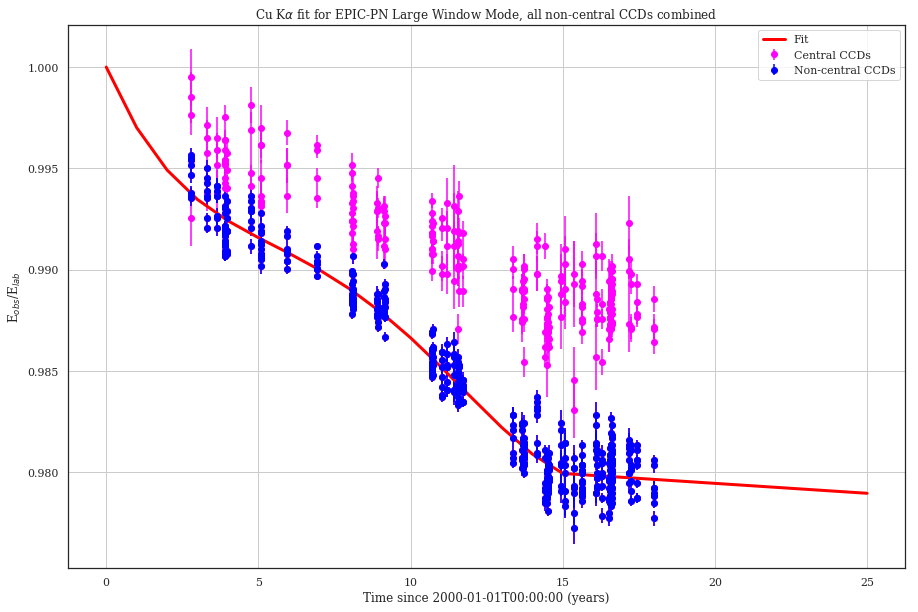

In [90]:
fig3, ax3 = plt.subplots(figsize=(15,10))
wtab = stab[(stab.ccd != 1) & (stab.ccd != 4) & (stab.ccd != 7) & (stab.ccd != 10)]
ax3.errorbar(stab.delta_time,stab.ratioE,yerr=stab.ratioE_err,fmt='o',color='magenta',label='Central CCDs')
ax3.errorbar(wtab.delta_time,wtab.ratioE,yerr=wtab.ratioE_err,fmt='o',color='blue',label='Non-central CCDs')
#
poly_order = 4
xin = wtab.delta_time
yin = wtab.ratioE
yin_err = wtab.ratioE_err
#
xin = pd.concat([pd.Series(0.0),xin])
yin = pd.concat([pd.Series(1.0),yin])
yin_err = pd.concat([pd.Series(1.0e-6),yin_err])
weights = 1.0/yin_err
#
z = np.polyfit(xin,yin,poly_order,w=weights)
ws = np.poly1d(z)
wresult = ws(tt)
#
# now make it so that from the first data point the curve goes linearly to (0.0,1.0)
# slope m = (y2-y1)/(x2-x1) in thie case y1=1.0 and x1 = 0.0, (x2,y2) is the first data point
#m0 = (yin.values[1] - 1.0)/xin.values[1]
#i0 = int(np.ceil(xin.values[1]))
#wresult[0:i0] = m0*tt[0:i0] + 1.0
# try linear from tt=16 to tt=25 with result[16] and result[24] = result[16]*0.999
# as the rate of change after t=16
xrate = 0.999
istart = 15
m = (wresult[istart]*xrate - wresult[istart])/(tt[-1] - tt[istart])
wresult[istart:] = m*(tt[istart:] - tt[istart]) + wresult[istart]
#
ax3.plot(tt,wresult,label='Fit',linewidth=3,color='red')
ax3.grid()
ax3.set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode, all non-central CCDs combined")
ax3.set_ylabel(r"E$_{obs}$/E$_{lab}$")
ax3.set_xlabel("Time since 2000-01-01T00:00:00 (years)")
ax3.legend();

## Test 2: Combine the non-central CCDs per quadrant

The idea is to combine all non-central CCDs and derive a curve based on quadrant: 
* `Q_0`:  CCD 2 & 3 and use it for CCD 1
* `Q_1`: CCD 5 & 6 and use it for CCD 4
* `Q_2`: CCD 8 & 9 and use it for CCD 7
* `Q_3`: CCD 11 & 12 and use it for CCD 10

The long-term CTI correction for each of the central 4 CCDs will be the combined one, per quadrant. I.e. the curve for the boresight `CCDNR=4` will be the curve for quadrant `Q_1` etc.

For each individal non-central CCD we have two options: 
1. `test1`: Use the derived curve for this CCD
2. `test2`: Use the combined curve for the quadrant


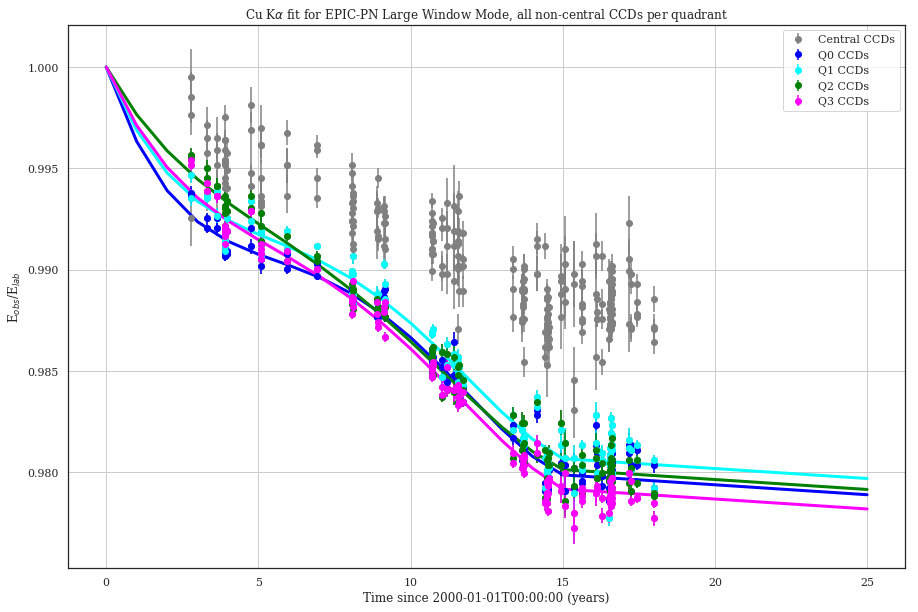

In [92]:
fig3, ax3 = plt.subplots(figsize=(15,10))
qtab = {}
qtab['q0'] = stab[(stab.ccd == 2) | (stab.ccd == 3)]
qtab['q1'] = stab[(stab.ccd == 5) | (stab.ccd == 6)]
qtab['q2'] = stab[(stab.ccd == 8) | (stab.ccd == 9)]
qtab['q3'] = stab[(stab.ccd == 11) | (stab.ccd == 12)]
#
ax3.errorbar(stab.delta_time,stab.ratioE,yerr=stab.ratioE_err,fmt='o',color='gray',label='Central CCDs')
#
poly_order = 4
#
xcol = ['blue','cyan','green','magenta']
qresult = {}
qws = {}
#
for i,iq in enumerate(['q0','q1','q2','q3']):
    xin = qtab[iq].delta_time
    yin = qtab[iq].ratioE
    yin_err = qtab[iq].ratioE_err
    ax3.errorbar(xin,yin,yerr=yin_err,fmt='o',color=xcol[i],label=f'{iq.upper()} CCDs')
    #
    xin = pd.concat([pd.Series(0.0),xin])
    yin = pd.concat([pd.Series(1.0),yin])
    yin_err = pd.concat([pd.Series(1.0e-6),yin_err])
    weights = 1.0/yin_err
    #
    z = np.polyfit(xin,yin,poly_order,w=weights)
    qws[iq] = np.poly1d(z)
    qresult[iq] = qws[iq](tt)
    #
    # now make it so that from the first data point the curve goes linearly to (0.0,1.0)
    # slope m = (y2-y1)/(x2-x1) in thie case y1=1.0 and x1 = 0.0, (x2,y2) is the first data point
    #m0 = (yin.values[1] - 1.0)/xin.values[1]
    #i0 = int(np.ceil(xin.values[1]))
    #wresult[0:i0] = m0*tt[0:i0] + 1.0
    # try linear from tt=16 to tt=25 with result[16] and result[24] = result[16]*0.999
    # as the rate of change after t=16
    xrate = 0.999
    istart = 15
    m = (qresult[iq][istart]*xrate - qresult[iq][istart])/(tt[-1] - tt[istart])
    qresult[iq][istart:] = m*(tt[istart:] - tt[istart]) + qresult[iq][istart]
    #
    ax3.plot(tt,qresult[iq],linewidth=3,color=xcol[i],label='')
ax3.grid()
ax3.set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode, all non-central CCDs per quadrant")
ax3.set_ylabel(r"E$_{obs}$/E$_{lab}$")
ax3.set_xlabel("Time since 2000-01-01T00:00:00 (years)")
ax3.legend();

## Check the residuals of the fit

It is useful to check the residuals for any long-term effects, which we actually want to remove.

Added the residual if we consider one curve for the non-central CCDs.

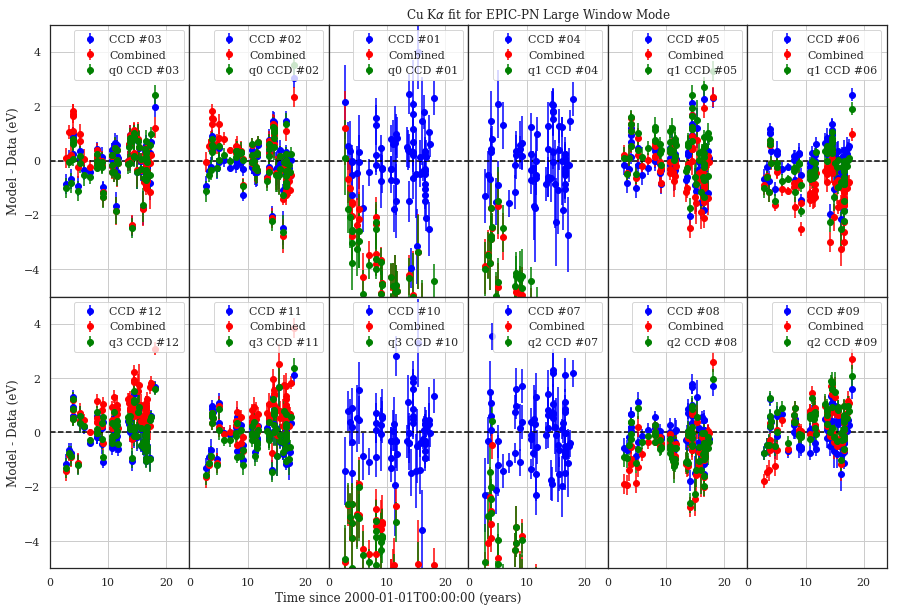

In [97]:
#
# will use the residuals from the previous cell to plot
#
fig2, axs2 = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
#
# quadrants assignment
quad = {1: 'q0', 2: 'q0',3: 'q0',\
        4: 'q1', 5: 'q1',6: 'q1',\
        7: 'q2', 8: 'q2',9: 'q2',\
        10: 'q3', 11: 'q3',12: 'q3'}
#
for j in range(12):
    ccd = j+1
    xtab = stab[(stab.ccd == ccd) & (stab.ratioE < 1.0)]
    #
    xin = xtab.delta_time
    yin = xtab.ratioE
    yin_err = xtab.ratioE_err
    #
    kx = mapping[ccd][0]
    ky = mapping[ccd][1]
    #
    # now the residuals
    #
    yy1 = (fit_result[ccd](xin) - yin)*1000
    yy1_err = yin_err*1000
    yy0 = (ws(xin) - yin)*1000
    yy0_err = yin_err*1000
    # per quadrant
    iq = quad[ccd]
    yy2 = (qws[iq](xin) - yin)*1000
    yy2_err = yin_err*1000
    #
    axs2[kx,ky].errorbar(xin,yy1,yerr=yy1_err,fmt='o',color='blue',label=f'CCD #{ccd:02}')
    axs2[kx,ky].errorbar(xin,yy0,yerr=yy0_err,fmt='o',color='red',label=f'Combined')
    axs2[kx,ky].errorbar(xin,yy2,yerr=yy2_err,fmt='o',color='green',label=f'{iq} CCD #{ccd:02}')
    axs2[kx,ky].axhline(0.0,color='black',ls='dashed')
    axs2[kx,ky].set_xlim((0,24))
    axs2[kx,ky].set_ylim((-5.0,5.0))
    axs2[kx,ky].grid(True)
    axs2[kx,ky].legend(loc=1)
    if (ccd == 4):
        axs2[kx,ky].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode")
    if (ccd == 3 or ccd == 12):
        axs2[kx,ky].set_ylabel("Model - Data (eV)")
    if (ccd == 10):
        axs2[kx,ky].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
#plt.savefig(f"{wdir}/cuka_results_allccd_noctiy_residuals_plot.png",dpi=100)
#plt.show()
#plt.close()

## Derive one single correction curve using the individual correction curves

Alternatively, we can construct one single correction curve using the curves per CCD.

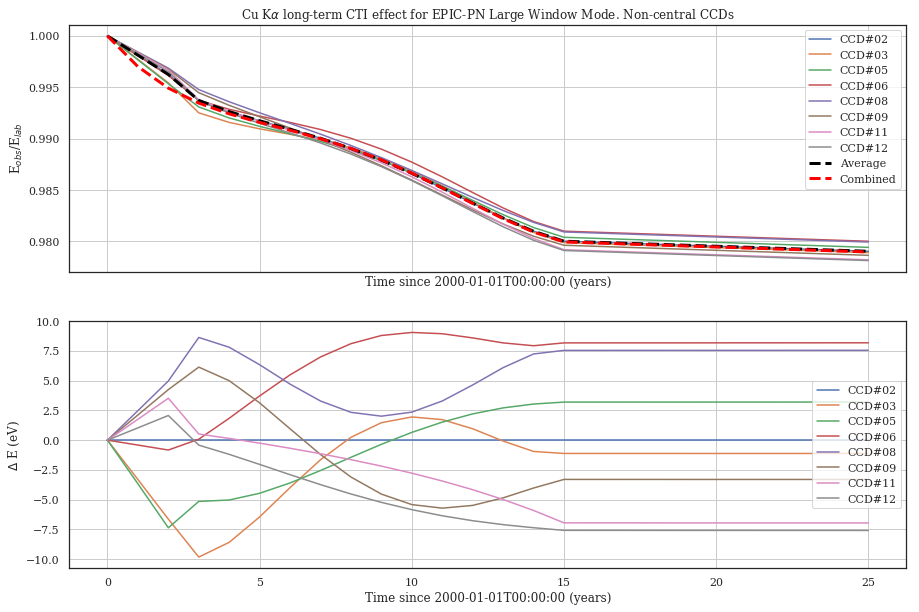

In [98]:
fig, axs = plt.subplots(2,1,sharex=True,figsize=(15,10))
#rawy = 190.0 # the boresight RAWY
for ccd in [2,3,5,6,8,9,11,12]:
    #coeff = 1.0 - np.power(results[ccd],1.0/190.0)
    axs[0].plot(tt,results[ccd],label=f'CCD#{ccd:02}')
    if (ccd == 2):
        mean_curve = results[ccd]
    else:
        mean_curve += results[ccd]
#
mean_curve /= 8
axs[0].plot(tt,mean_curve,label=f'Average',linestyle='dashed',color='black',linewidth=3)
axs[0].plot(tt,wresult,label=f'Combined',linestyle='dashed',color='red',linewidth=3)
#
axs[0].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
axs[0].set_ylabel(r"E$_{obs}$/E$_{lab}$")
axs[0].set_title(r"Cu K$\alpha$ long-term CTI effect for EPIC-PN Large Window Mode. Non-central CCDs")
#ax.set_ylabel(r"T_COEFF $\times 10^5$")
axs[0].grid(True)
#ax.set_title("Energy dependence at boresight, pinhole measurements, PANTHER 2004/2005")
axs[0].legend();
#plt.savefig(f'{wdir}/panther_energy_deps_plot.png',dpi=100)
#plt.show()
#plt.close()
#
# now the differences 
#
cuka = 8.04 # keV
cuka_mean = cuka/mean_curve
cuka_wmean = cuka/wresult
for ccd in [2,3,5,6,8,9,11,12]:
    #print (ccd,results[ccd][-1])
    cuka_x = cuka/results[ccd]
    #diff0 = (cuka_wmean - cuka_x)*1000.0
    diff = (cuka_mean - cuka_x)*1000.0
    #axs[1].plot(tt,diff0,'o',color='red',label='')
    axs[1].plot(tt,diff,label=f'CCD#{ccd:02}')
#
axs[1].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
axs[1].set_ylabel("$\Delta$ E (eV)")
axs[1].grid(True)
axs[1].legend();

## Check the expected results

Using the two tests, we correct the fitted no-CTI line energies and check the difference with the expected Cu K$\alpha$ line energy of 8.04 keV. 

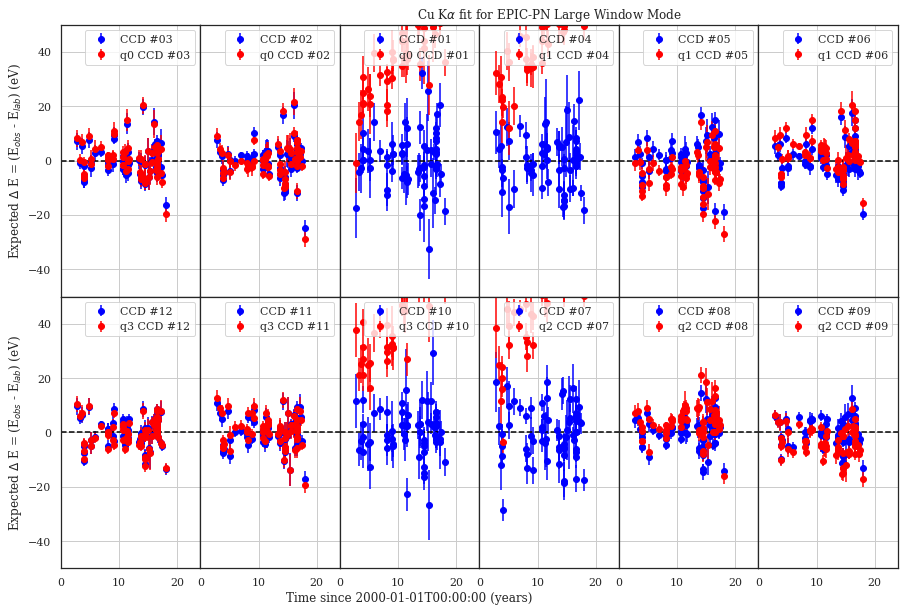

In [104]:
fig4, axs4 = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
#
# quadrants assignment
quad = {1: 'q0', 2: 'q0',3: 'q0',\
        4: 'q1', 5: 'q1',6: 'q1',\
        7: 'q2', 8: 'q2',9: 'q2',\
        10: 'q3', 11: 'q3',12: 'q3'}
#
cuka0 = 8.04 # keV
for j in range(12):
    ccd = j+1
    iq = quad[ccd]
    xtab = stab[(stab.ccd == ccd)]
    #
    xin = xtab.delta_time
    #
    # now the corrected line energy difference in eV
    #
    # index 1 is for individual CCD fit
    # index 2 is for the per quadrant ones
    yy1 = (xtab.lineE/fit_result[ccd](xin) - cuka0)*1000
    yy1_err = xtab.lineE_err*1000
    yy2 = (xtab.lineE/qws[iq](xin) - cuka0)*1000
    #
    kx = mapping[ccd][0]
    ky = mapping[ccd][1]
    #
    axs4[kx,ky].errorbar(xin,yy1,yerr=yy1_err,fmt='o',color='blue',label=f'CCD #{ccd:02}')
    axs4[kx,ky].errorbar(xin,yy2,yerr=yy1_err,fmt='o',color='red',label=f'{iq} CCD #{ccd:02}')
    axs4[kx,ky].axhline(0.0,color='black',ls='dashed')
    axs4[kx,ky].set_xlim((0,24))
    axs4[kx,ky].set_ylim((-50.0,50.0))
    axs4[kx,ky].grid(True)
    axs4[kx,ky].legend(loc=1)
    if (ccd == 4):
        axs4[kx,ky].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode")
    if (ccd == 3 or ccd == 12):
        axs4[kx,ky].set_ylabel("Expected $\Delta$ E = (E$_{obs}$ - E$_{lab}$) (eV)")
    if (ccd == 10):
        axs4[kx,ky].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
#plt.savefig(f"{wdir}/cuka_results_allccd_noctiy_residuals_plot.png",dpi=100)
#plt.show()
#plt.close()

## Prepare for the CCF

This step require the average RAWY per CCD and then convert the ratio Eobs/Elab to the $g(t)$  function:

$E_{obs}/E_{lab} = \left[\frac{1 - g(t)}{1-a_0}\right]^{RAWY}$,

where $a_0 = g(t_0)$, the measured CTI at launch. We know $a_0$ at 5.8988 keV but not at 8.04 keV. so we use the value for 5.8988 keV, $a_0 = 0.00043236$.

Rewriting the equation we obtain:

$g(t) = 1 - (1-a_0)\times (E_{obs}/E_{lab})^{1/RAWY}$.  

The tabulated function $g(t)$ is stored in the EPN_CTI calibartion file.

Will also investigate an alternative way, when $a_0$ is unknown. Then we can set it to zero:

$E_{obs}/E_{lab} = \left(1 - g(t)\right)^{RAWY}$,

and consequently 

$g(t) = 1 - (E_{obs}/E_{lab})^{1/RAWY}$.  



In [124]:
#
# results dictionary per CCD is the fitted Eobs/Elab (the red line).
#
gt = {}
gt2 = {}
gt3 = {}
for i in range(12):
    ccd = i + 1
    med_rawy = rawy['50%'].values[i]
    mean_rawy = rawy['mean'].values[i]
    #mean_rawy = rawy['mean'].values[i]
    a0_x = a0[ccd]
    gt[ccd] = 1.0 - (1.0 - a0[ccd])*np.power(results[ccd],1.0/mean_rawy)
    gt3[ccd] = 1.0 - (1.0 - a0[ccd])*np.power(results[ccd],1.0/med_rawy)
    gt[ccd][0] = a0[ccd]
    gt3[ccd][0] = a0[ccd]
    gt2[ccd] = 1.0 - np.power(results[ccd],1.0/mean_rawy)
#

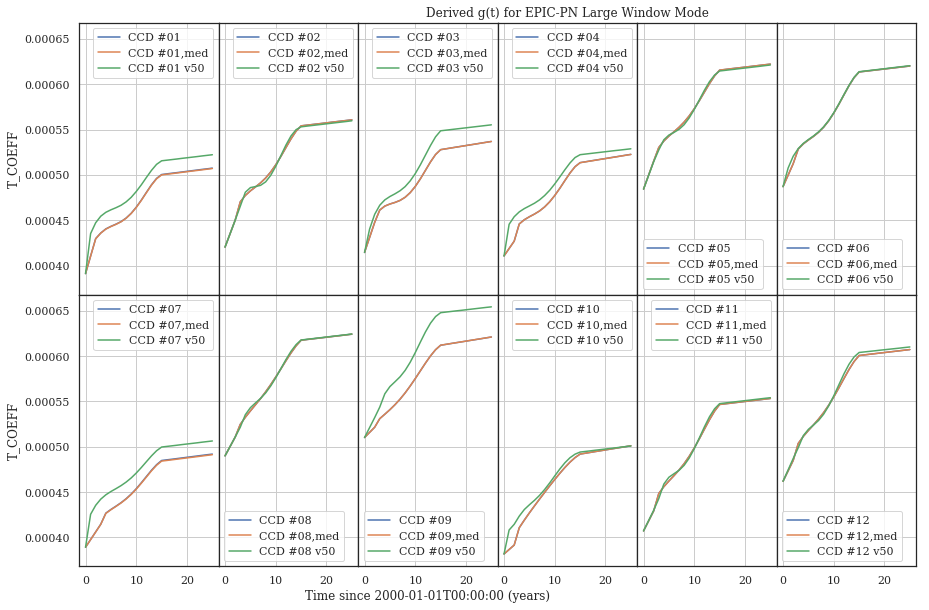

In [125]:
#
# now plot and compare
#
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
for j in range(12):
    ccd = j+1
    #
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs[kj,k].plot(tt,gt[ccd],label=f'CCD #{ccd:02}')
    #axs[kj,k].plot(tt,gt2[ccd],label=f'CCD #{ccd:02},a0=0')
    axs[kj,k].plot(tt,gt3[ccd],label=f'CCD #{ccd:02},med')
    axs[kj,k].plot(tt,coef[ccd],label=f'CCD #{ccd:02} v50')
    axs[kj,k].legend()
    axs[kj,k].grid(True)
    if (ccd == 4):
        axs[kj,k].set_title("Derived g(t) for EPIC-PN Large Window Mode")
    if (ccd == 7 or ccd == 1):
        axs[kj,k].set_ylabel("T_COEFF")
    if (ccd == 9):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kj,k].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
    
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig(f"{wdir}/cuka_tcoef_v50_v51.png",dpi=100)
plt.show()
plt.close();

## Plot the expected results

Using the observed data we apply the newly derived long-term CTI. Will use inteprolation for time and assume all photons arrive from RAWY equal to the mean RAWY.


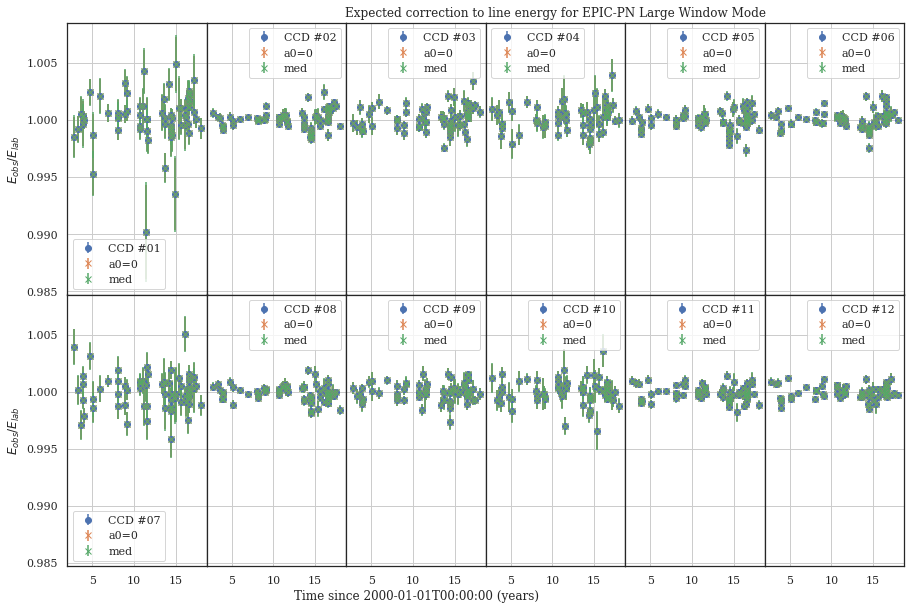

In [126]:
wdir = f"{home}/IVAN/Cu-line"
t = Table.read(f'{wdir}/fit_results_cuka_noctix.csv',comment="\s*#")
t["ratioE"] = Column(t["lineE"]/8.04)
t["ratioE_err"] = Column(t["lineE_err"]/8.04)
tab = t.to_pandas()
stab = tab.sort_values(['delta_time'])
#
# expected results, as ratio
#
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))

for j in range(12):
    ccd = j + 1
    mean_rawy = rawy['mean'].values[j]
    med_rawy = rawy['50%'].values[j]
    # now use g(t)
    xtab = stab[stab.ccd == ccd]
    # the input data
    xin = xtab.delta_time
    yin = xtab.lineE
    yin_err = xtab.lineE_err
    # now calculate the correction
    ltcti = np.power((1.0 - gt[ccd])/(1.0 - gt[ccd][0]),mean_rawy)
    ltcti2 = np.power((1.0 - gt2[ccd]),mean_rawy)
    ltcti3 = np.power((1.0 - gt3[ccd]),med_rawy)
    # the correction at the time of observation
    ltcti_x = np.interp(xin,tt,ltcti)
    ltcti2_x = np.interp(xin,tt,ltcti2)
    ltcti3_x = np.interp(xin,tt,ltcti3)
    # and apply the correction to get the new line energy 
    E_new = yin/ltcti_x
    E_new_err = yin_err/ltcti_x
    xratio = E_new/8.04
    xratio_err = E_new_err/8.04
    #
    E_new2 = yin/ltcti2_x
    E_new2_err = yin_err/ltcti2_x
    xratio2 = E_new2/8.04
    xratio2_err = E_new2_err/8.04
    #
    #
    E_new3 = yin/ltcti3_x
    E_new3_err = yin_err/ltcti3_x
    xratio3 = E_new2/8.04
    xratio3_err = E_new3_err/8.04
    # now plotting
    #
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs[kj,k].errorbar(xin,xratio,yerr=(xratio_err,xratio_err),fmt = 'o',label=f'CCD #{ccd:02}')
    axs[kj,k].errorbar(xin,xratio2,yerr=(xratio2_err,xratio2_err),fmt = 'x',label="a0=0")
    axs[kj,k].errorbar(xin,xratio3,yerr=(xratio3_err,xratio3_err),fmt = 'x',label="med")
    axs[kj,k].legend()
    axs[kj,k].grid(True)
    if (ccd == 4):
        axs[kj,k].set_title("Expected correction to line energy for EPIC-PN Large Window Mode")
    if (ccd == 7 or ccd == 1):
        axs[kj,k].set_ylabel("$E_{obs}/E_{lab}$")
    if (ccd == 9):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kj,k].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
    
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig(f"{wdir}/cuka_tcoef_v50_v51.png",dpi=100)
plt.show();
#plt.close();#

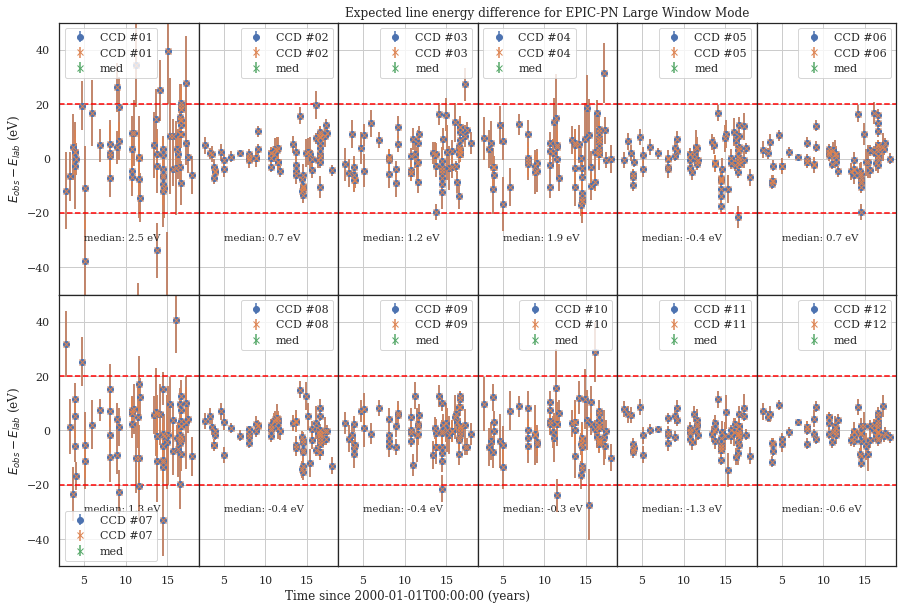

In [128]:
#
# expected results, as difference
#
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))

for j in range(12):
    ccd = j + 1
    mean_rawy = rawy['mean'].values[j]
    med_rawy = rawy['mean'].values[j]
    # now use g(t)
    xtab = stab[stab.ccd == ccd]
    # the input data
    xin = xtab.delta_time
    yin = xtab.lineE
    yin_err = xtab.lineE_err
    # now calculate the correction
    ltcti = np.power((1.0 - gt[ccd])/(1.0 - gt[ccd][0]),mean_rawy)
    ltcti2 = np.power((1.0 - gt2[ccd]),mean_rawy)
    ltcti3 = np.power((1.0 - gt3[ccd]),med_rawy)
    # the correction at the time of observation
    ltcti_x = np.interp(xin,tt,ltcti)
    ltcti2_x = np.interp(xin,tt,ltcti2)
    ltcti3_x = np.interp(xin,tt,ltcti3)
    # and apply the correction to get the new line energy 
    E_new = yin/ltcti_x
    E_new_err = yin_err/ltcti_x
    xdiff = 1000*(E_new - 8.04)
    med = np.median(xdiff)
    xdiff_err = 1000*E_new_err
    #
    E_new2 = yin/ltcti2_x
    E_new2_err = yin_err/ltcti2_x
    xdiff2 = 1000*(E_new2 - 8.04)
    med2 = np.median(xdiff2)
    xdiff2_err = 1000*E_new2_err
    #
    E_new3 = yin/ltcti3_x
    E_new3_err = yin_err/ltcti3_x
    xdiff3 = 1000*(E_new3 - 8.04)
    med3 = np.median(xdiff3)
    xdiff3_err = 1000*E_new3_err
    # now plotting
    #
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs[kj,k].errorbar(xin,xdiff,yerr=(xdiff_err,xdiff_err),fmt = 'o',label=f'CCD #{ccd:02}')
    axs[kj,k].errorbar(xin,xdiff2,yerr=(xdiff2_err,xdiff2_err),fmt = 'x',label=f'CCD #{ccd:02}')
    axs[kj,k].errorbar(xin,xdiff3,yerr=(xdiff3_err,xdiff3_err),fmt = 'x',label=f'med')
    axs[kj,k].axhline(-20.0,linestyle='dashed',color='red')
    axs[kj,k].axhline(20.0,linestyle='dashed',color='red')
    axs[kj,k].text(5.0,-30.0,f"median: {med:.1f} eV")
    axs[kj,k].set_ylim((-50,50))
    axs[kj,k].legend()
    axs[kj,k].grid(True)
    if (ccd == 4):
        axs[kj,k].set_title("Expected line energy difference for EPIC-PN Large Window Mode")
    if (ccd == 7 or ccd == 1):
        axs[kj,k].set_ylabel("$E_{obs} - E_{lab}$ (eV)")
    if (ccd == 9):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kj,k].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
    
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig(f"{wdir}/cuka_tcoef_v50_v51.png",dpi=100)
plt.show();
#plt.close();#

## Generate a new CTI CCF file

Will reuse the current one and just update `TCOEFF` with the new results 

In [88]:
import time
today = time.strftime("%c")
#
ccfdir = '/ccf/pub'
ccf50_file = f"{ccfdir}/EPN_CTI_0050.CCF"
hdu50 = fits.open(f"{ccf50_file}")
ltc50 = hdu50['LONG_TERM_CTI']
n50 = len(ltc50.data)
#

In [49]:
for i in np.arange(n50):
    # we only change MODE_ID = 2, i.e. Large Window Mode
    if (ltc50.data['MODE_ID'][i] != 2):
        continue
    # and we only change the TCOEFF for energy 8.04 keV
    if (ltc50.data['ENERGY'][i] < 8.0):
        continue
    # now loop over the CCDNR
    for j in np.arange(1,13):
        if (ltc50.data['CCD_ID'][i] == j):
            ltc50.data['T_COEFF'][i] = gt[j]
            break
        #
    #
#
if ('HISTORY' in hdu50['LONG_TERM_CTI'].header.keys()):
    hdu50['LONG_TERM_CTI'].header.remove('HISTORY',remove_all=True)
hdu50['LONG_TERM_CTI'].header.add_history(f'Created by Ivan V, {today}')
hdu50[0].header['FILENAME'] = "EPN_CTI_0051.CCF"
hdu50.writeto(f"{wdir}/../ccfdev/EPN_CTI_0051.CCF_test01",overwrite=False)
hdu50.close()

## Testing CCF with $a_0 = 0$

In this case, the results show some median offset for CCDs which we try to correct for

In [90]:
#
# for the a0=0 tests, some ccds results are not offset, I will try to correct by 
corrx = np.ones(12,dtype=float)
corrx[0] = -10.0
corrx[1] = 2.0
corrx[2] = 1.0
corrx[3] = 3.0
corrx[4] = 2.0
corrx[5] = 5.0
corrx[6] = -13.0
corrx[7] = 3.0
corrx[8] = 1.0
corrx[9] = -1.0
corrx[10] = 3.0
corrx[11] = 5.0
#
corrx = 1.0 + corrx/8040.0

for i in np.arange(n50):
    # we only change MODE_ID = 2, i.e. Large Window Mode
    if (ltc50.data['MODE_ID'][i] != 2):
        continue
    # and we only change the TCOEFF for energy 8.04 keV
    if (ltc50.data['ENERGY'][i] < 8.0):
        continue
    # now loop over the CCDNR
    for j in np.arange(1,13):
        if (ltc50.data['CCD_ID'][i] == j):
            mean_rawy = rawy['mean'].values[j-1]
            newcor = np.power(corrx[j-1],1.0/mean_rawy)
            ltc50.data['T_COEFF'][i] = gt2[j]*newcor
            break
        #
    #
#
if ('HISTORY' in hdu50['LONG_TERM_CTI'].header.keys()):
    hdu50['LONG_TERM_CTI'].header.remove('HISTORY',remove_all=True)
hdu50['LONG_TERM_CTI'].header.add_history(f'Created by Ivan V, {today}')
hdu50[0].header['FILENAME'] = "EPN_CTI_0051.CCF"
hdu50.writeto(f"{wdir}/../ccfdev/EPN_CTI_0051.CCF_test03",overwrite=True)
hdu50.close()

## Compare the new CCF with the current one

Just in case, we check if they are different.

One way to check is with plotting, another way is to dump the content to an ascii files and do `diff` from the OS.


In [51]:
def dump_cti(ccf_file,fileout=None):
    #
    # will dump the LONG_TERM_CTI extension in an ascii file with format following the standard one
    #
    hdu = fits.open(ccf_file)
    extname = 'LONG_TERM_CTI'
    ltc = hdu[extname]
    nt = len(ltc.data)
    if (fileout != None):
        fout = open(fileout,'w')
    #
    for j in np.arange(nt):
        if (fileout != None):
            print ("{:3} : {:3} :   {:6.4f} : ".format(ltc.data['MODE_ID'][j],ltc.data['CCD_ID'][j],\
               ltc.data['ENERGY'][j]),end="",file=fout)
        print ("{:3} : {:3} :   {:6.4f} : ".format(ltc.data['MODE_ID'][j],ltc.data['CCD_ID'][j],\
               ltc.data['ENERGY'][j]),end="",file=fout)
        tcoeff = ltc.data['T_COEFF']
        nrow,ncol = tcoeff.shape
        for l in np.arange(ncol):
            print ("  {:3.6e}".format(tcoeff[j,l]),end="",file=fout)
        print (" :   1",file=fout)
        #
    #    
    if (fileout != None):
        fout.close()
    return fileout

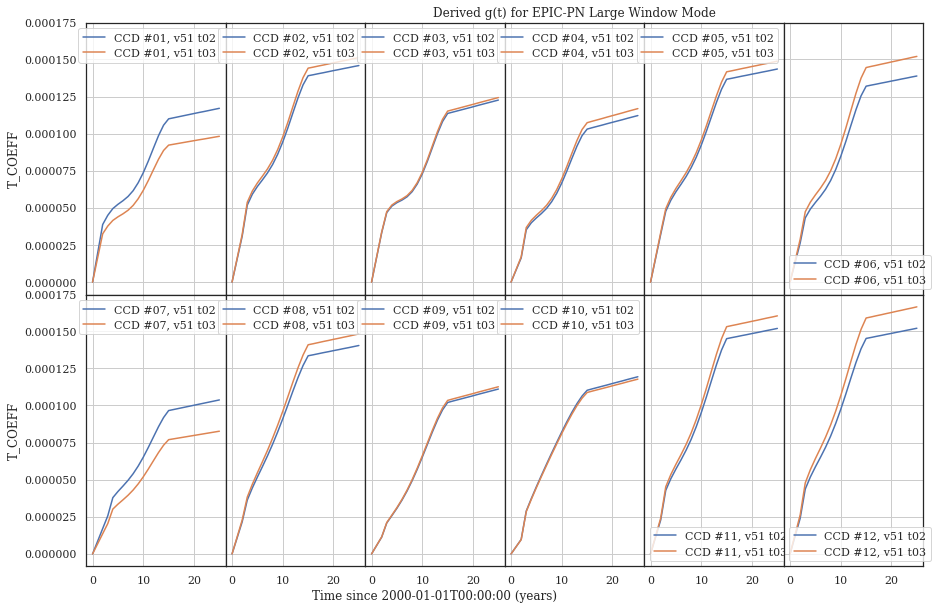

In [92]:
ccfdir = '/ccf/pub'
ccf50_file = f"{ccfdir}/EPN_CTI_0050.CCF"
t50 = read_cti_ccf(ccf50_file,mode_id=2,energy_index=2)
x50 = t50[1]['times']
#
ccfdevdir = f'{home}/IVAN/ccfdev'
ccf51_file = f"{ccfdevdir}/EPN_CTI_0051.CCF_test02"
t51a = read_cti_ccf(ccf51_file,mode_id=2,energy_index=2)
x51a = t51a[1]['times']
ccf51_file = f"{ccfdevdir}/EPN_CTI_0051.CCF_test03"
t51b = read_cti_ccf(ccf51_file,mode_id=2,energy_index=2)
x51b = t51b[1]['times']
#
# dump to ascii
#
#fx50 = dump_cti(ccf50_file,fileout=f"{ccfdevdir}/long_term_cti_0051.dat_test02")
#fx51 = dump_cti(ccf51_file,fileout=f"{ccfdevdir}/long_term_cti_0051.dat_test03")
#
# now plot and compare
#
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
for j in range(12):
    ccd = j+1
    #
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    y50 = t50[ccd]['tcoeff']
    y51a = t51a[ccd]['tcoeff']
    y51b = t51b[ccd]['tcoeff']
    #axs[kj,k].plot(x50,y50,label=f'CCD #{ccd:02}, v50')
    axs[kj,k].plot(tt,y51a,label=f'CCD #{ccd:02}, v51 t02')
    axs[kj,k].plot(tt,y51b,label=f'CCD #{ccd:02}, v51 t03')
    axs[kj,k].legend()
    axs[kj,k].grid(True)
    if (ccd == 4):
        axs[kj,k].set_title("Derived g(t) for EPIC-PN Large Window Mode")
    if (ccd == 7 or ccd == 1):
        axs[kj,k].set_ylabel("T_COEFF")
    if (ccd == 9):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kj,k].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
    
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig(f"{wdir}/cuka_tcoef_v50_v51.png",dpi=100)
plt.show()
plt.close();

## Check the results after applying the correction

Current run is with `EPN_CTI_0051.CCF_test01 = EPN_CTI_0051.CCF`

In [83]:
wdir = f"{home}/IVAN/Cu-line"
t = Table.read(f'{wdir}/fit_results_cuka_cti51x.csv',comment="\s*#")
#t = Table.read(f'{wdir}/fit_results_cuka_cti51x.csv',comment="\s*#")
t["ratioE"] = Column(t["lineE"]/8.04)
t["ratioE_err"] = Column(t["lineE_err"]/8.04)
t["diffE"] = Column(t["lineE"] - 8.04)
t["diffE_err"] = Column(t["lineE_err"])
tab_x = t.to_pandas()

In [84]:
wdir = f"{home}/IVAN/Cu-line"
t = Table.read(f'{wdir}/fit_results_cuka_cti51z.csv',comment="\s*#")
#t = Table.read(f'{wdir}/fit_results_cuka_cti51x.csv',comment="\s*#")
t["ratioE"] = Column(t["lineE"]/8.04)
t["ratioE_err"] = Column(t["lineE_err"]/8.04)
t["diffE"] = Column(t["lineE"] - 8.04)
t["diffE_err"] = Column(t["lineE_err"])
tab_y = t.to_pandas()

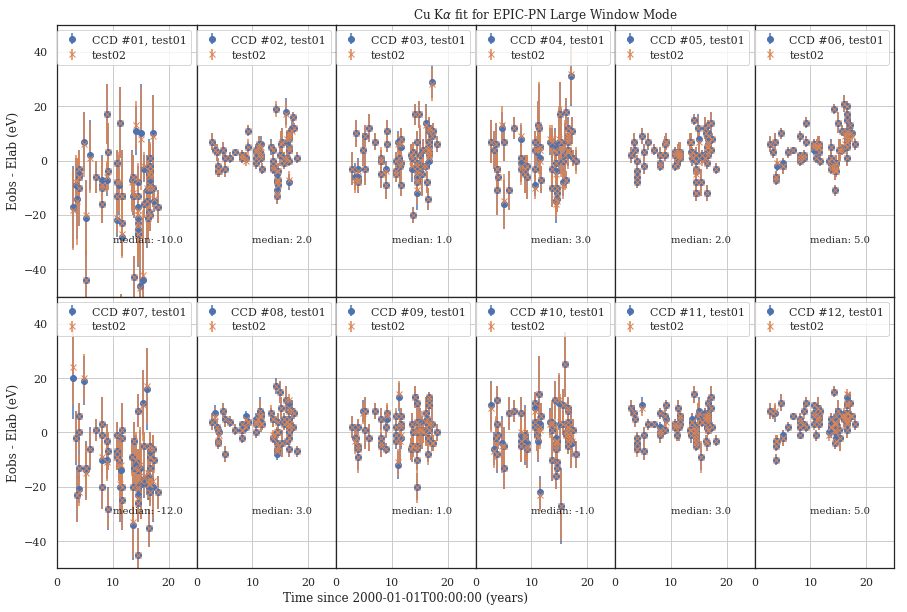

In [86]:
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
stab_x = tab_x.sort_values(['delta_time'])
stab_y = tab_y.sort_values(['delta_time'])
#
for j in range(12):
    ccd = j+1
    xtab1 = stab_x[stab_x.ccd == ccd]
    xtab2 = stab_y[stab_y.ccd == ccd]
    #
    xin1 = xtab1.delta_time
    yin1 = xtab1.diffE*1000.0 # in eV
    med1 = np.median(yin1)
    yin1_err = xtab1.diffE_err*1000.0 # in eV
    #
    xin2 = xtab2.delta_time
    yin2 = xtab2.diffE*1000.0 # in eV
    med2 = np.median(yin2)
    yin2_err = xtab2.diffE_err*1000.0 # in eV
    #
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs[kj,k].errorbar(xin1,yin1,yerr=(yin1_err,yin1_err),fmt='o',label=f'CCD #{ccd:02}, test01')
    axs[kj,k].errorbar(xin2,yin2,yerr=(yin2_err,yin2_err),fmt='x',label=f'test02')
    axs[kj,k].text(10,-30,f'median: {med2:.1f}')
    axs[kj,k].set_xlim((0,25))
    axs[kj,k].set_ylim((-50.0,50.0))
    axs[kj,k].grid(True)
    axs[kj,k].legend()
    if (ccd == 4):
        axs[kj,k].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode")
    if (ccd == 7 or ccd == 1):
        axs[kj,k].set_ylabel("Eobs - Elab (eV)")
    if (ccd == 9):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kj,k].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
#plt.savefig(f"{wdir}/cuka_results_nocti_ccf50_vs_ccf51.png",dpi=100)
plt.show();
plt.close();

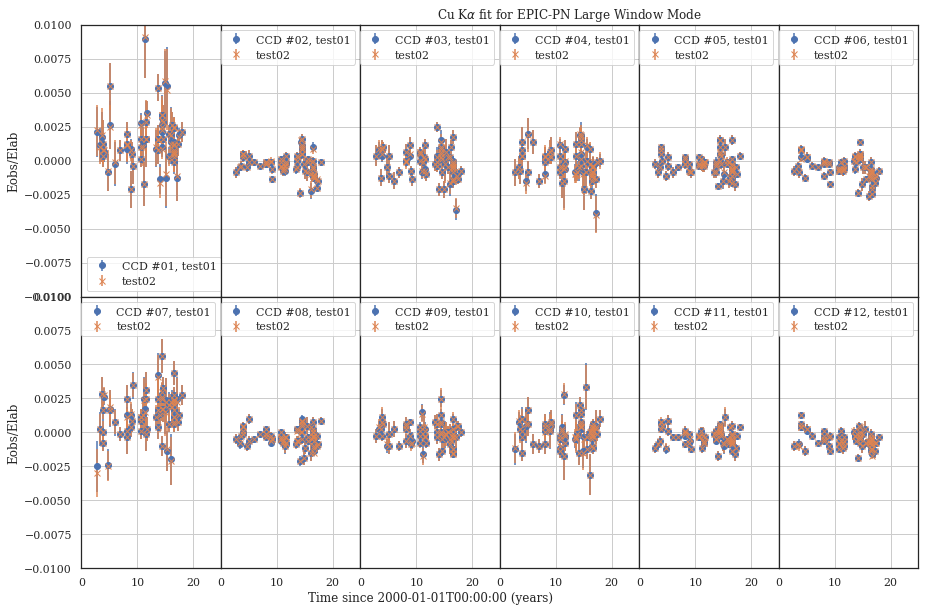

In [116]:
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
stab_x = tab_x.sort_values(['delta_time'])
stab_y = tab_y.sort_values(['delta_time'])
#
for j in range(12):
    ccd = j+1
    xtab1 = stab_x[stab_x.ccd == ccd]
    xtab2 = stab_y[stab_y.ccd == ccd]
    #
    xin1 = xtab1.delta_time
    yin1 = 1.0 - xtab1.ratioE
    med1 = np.median(yin1)
    yin1_err = xtab1.ratioE_err
    #
    xin2 = xtab2.delta_time
    yin2 = 1.0 - xtab2.ratioE
    med2 = np.median(yin2)
    yin2_err = xtab2.ratioE_err
    #
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs[kj,k].errorbar(xin1,yin1,yerr=(yin1_err,yin1_err),fmt='o',label=f'CCD #{ccd:02}, test01')
    axs[kj,k].errorbar(xin2,yin2,yerr=(yin2_err,yin2_err),fmt='x',label=f'test02')
    #axs[kj,k].text(10,-0.1,f'median: {100*med2:.1f}')
    axs[kj,k].set_xlim((0,25))
    axs[kj,k].set_ylim((-0.01,0.01))
    axs[kj,k].grid(True)
    axs[kj,k].legend()
    if (ccd == 4):
        axs[kj,k].set_title(fr"Cu K$\alpha$ fit for EPIC-PN Large Window Mode")
    if (ccd == 7 or ccd == 1):
        axs[kj,k].set_ylabel("Eobs/Elab")
    if (ccd == 9):
        #axs[kj,k].set_xlabel("Revolution")
        axs[kj,k].set_xlabel("Time since 2000-01-01T00:00:00 (years)")
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
#plt.savefig(f"{wdir}/cuka_results_nocti_ccf50_vs_ccf51.png",dpi=100)
plt.show();
plt.close();

## Correcting $g(t)$ to fix the systematic offset

In order to correct the tabulated function $g(t)$ with the visible systematic offsets we derive a correction $x$ to multiply $g(t)$ with the following steps:

$E_{obs} - E_{lab} = \Delta$

$E_{obs}/E_{lab} = [1- xg(t)]^{y}$

Hence, solving for $x$: 

$x = 1 - (1 + \Delta/E_{lab})^{1/y} \approx \Delta/(y\ E_{lab})$, 

using the expansion $(1+x)^\alpha \approx 1+x\alpha$ for $x << 1$ and $x\alpha << 1$.

Here $E_{obs}$ is the observed line energy, $E_{lab} = 8040$ eV is the Cu K$\alpha$ line energy in eV, $\Delta$ is the difference in eV and $y$ is the mean `RAWY`.

In [96]:
1.0 - np.power((1.0 + 10.0/8040.0),1.0/145.0)

-8.572507361748194e-06

In [94]:
10.0/8040.0/145.0

8.57780065191285e-06